In [ ]:
#IMPORTS

In [4]:
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 19.5 MB 9.5 MB/s            


In [3]:
import numpy as np
from mosplot.plot import load_lookup_table, Mosfet, Expression

In [4]:
lookup_table = load_lookup_table("/home/fmeireles/Desktop/teste3/gmid-main/tests/lookup_table_generator/freepdk45/freepdk45_2.npz")

In [5]:
print(lookup_table.keys())

dict_keys(['NMOS_VTH', 'PMOS_VTH', 'description', 'simulator', 'parameter_names', 'device_parameters'])


In [6]:
#Making Simple Plots

In [112]:
nmos = Mosfet(lookup_table=lookup_table, mos="NMOS_VTH", vbs=0.0, vds=0.6, vgs=(0.23, 1.1))
pmos = Mosfet(lookup_table=lookup_table, mos="PMOS_VTH", vbs=0.0, vds=-0.6, vgs=(-1.2, -0.3))

In [113]:
print(nmos.length)

[4.50e-08 9.00e-08 1.35e-07 1.80e-07 2.25e-07 2.70e-07 3.15e-07 3.60e-07
 4.05e-07 4.50e-07 4.95e-07 5.40e-07 5.85e-07 6.30e-07 6.75e-07 7.20e-07
 7.65e-07 8.10e-07 8.55e-07 9.00e-07]


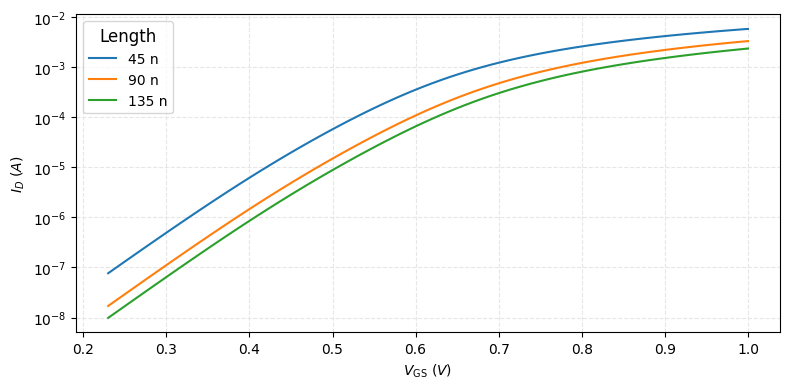

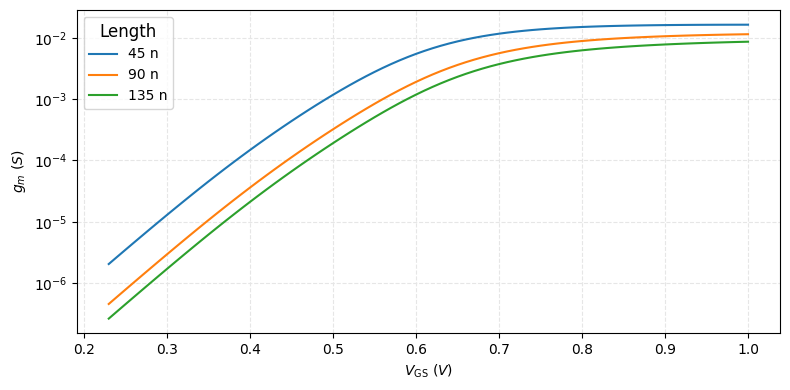

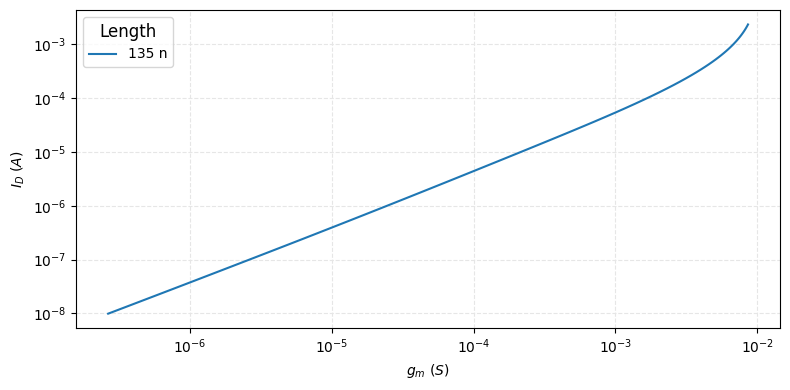

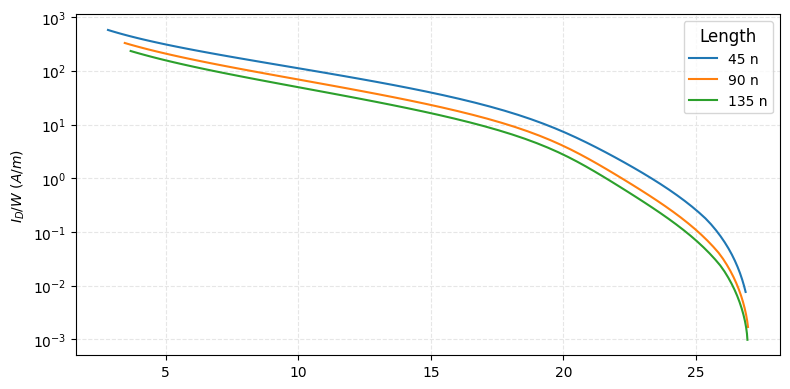

In [115]:
nmos.plot_by_expression(
    x_expression = nmos.vgs_expression,
    y_expression = nmos.id_expression,
    filtered_values = nmos.length[:3],
    y_scale="log",
    #save_fig="/home/just/Desktop/teste3/gmid-main/figures/teste_imagem.svg"
    # there are many other plot related options
)
nmos.plot_by_expression(
    x_expression = nmos.vgs_expression,
    y_expression = nmos.gm_expression,
    filtered_values = nmos.length[:3],
    y_scale="log",
    #save_fig="/home/just/Desktop/teste3/gmid-main/figures/teste_imagem.svg"
    # there are many other plot related options
)
nmos.plot_by_expression(
    x_expression = nmos.gm_expression,
    y_expression = nmos.id_expression,
    filtered_values = nmos.length[2],
    y_scale="log",
    x_scale="log",
    #save_fig="/home/just/Desktop/teste3/gmid-main/figures/teste_imagem.svg"
    # there are many other plot related options
)
nmos.plot_by_expression(
    y_expression = nmos.current_density_expression,
    x_expression = Expression(
        variables=["gm", "id"],#Rever isto 
        function=lambda x, y: x / (y),
        ),
    filtered_values = nmos.length[:3],
    y_scale="log",

    #save_fig="/home/just/Desktop/teste3/gmid-main/figures/teste_imagem.svg"
    # there are many other plot related options
)

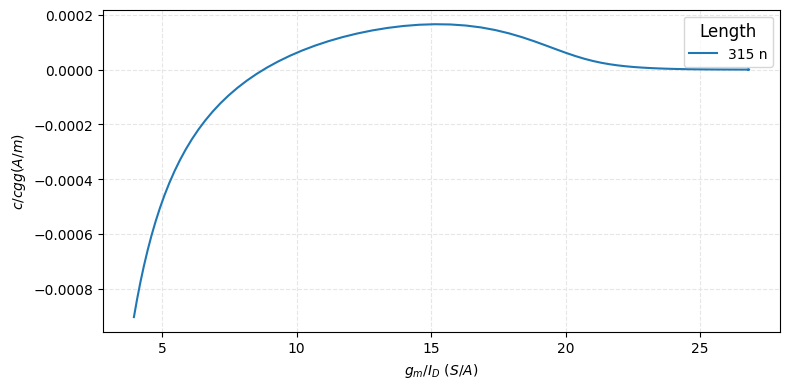

In [127]:
nmos.plot_by_expression(
    x_expression = nmos.gmid_expression,
    y_expression = Expression(
        variables=["cgd", "cgg"],
        function=lambda x, y: (x / y),
        label="$c / cgg (A/m)$",
    ),
    #y_scale="log",
    filtered_values = nmos.length[6],
    #y_scale="log",
    #save_fig="/home/just/Desktop/teste3/gmid-main/figures/teste_imagem.svg"
    # there are many other plot related options
)

In [19]:
import numpy as np
from scipy import constants
from dataclasses import dataclass
from typing import Optional
#
# Constants
k = constants.Boltzmann
TEMP = 300  # Kelvin

# --------------------------------------------
# Data Structures
# --------------------------------------------
@dataclass
class Specs:
    """Design specifications"""
    ts: float         # Settling time (s)
    fu1: float        # Unity gain freq (Hz)
    fp2: float        # Non-dominant pole (Hz)
    vod_noise: float  # Input-referred noise (V)
    G: float          # Closed-loop gain
    FO: float         # Fan-out
    L0: float         # Open-loop gain spec

@dataclass
class DesignParams:
    """Assumed parameters"""
    beta: float = None         # Will be computed as 0.75*beta_max
    beta_max: float = None     # Derived from G when not provided
    slew_frac: float = 0.3     # Slew fraction of ts
    rself1: float = 0.4        # Self-loading factor stage 1
    rself2: float = 0.4        # Self-loading factor stage 2
    cgs2_cc: float = 1/3       # Cgs2/CC ratio
    cltot_cc: float = 1.0      # CLtot/CC initial assumption
    gm3_gm1: float = 1.0       # M3/M1 gm ratio
    gm4_gm2: float = 1.0       # M4/M2 gm ratio
    gam1: float = 0.8          # Noise coeff M1
    gam2: float = 0.8          # Noise coeff M2
    gam3: float = 0.8          # Noise coeff M3
    gam4: float = 0.8          # Noise coeff M4

@dataclass
class Transistor:
    """Transistor design parameters with PDK properties"""
    L: float                    # Channel length [m]
    # Design variables
    gm: Optional[float] = None  # Transconductance [S]
    id: Optional[float] = None  # Drain current [A]
    gm_id: Optional[float] = None  # gm/ID ratio [S/A]
    w: Optional[float] = None   # Width [m]
    # Capacitances
    cgg: Optional[float] = None  # Total gate cap [F]
    cgs: Optional[float] = None  # Gate-source cap [F]
    cgd: Optional[float] = None  # Gate-drain cap [F]
    cdd: Optional[float] = None  # Drain-bulk cap [F]
    
    id_w: Optional[float] = None  # Current density [A/m]
    cgg_w: Optional[float] = None  # Gate cap per width [F/m]
    cgs_w: Optional[float] = None  # Cgs per width [F/m]
    cgd_w: Optional[float] = None  # Cgd per width [F/m]
    cdd_w: Optional[float] = None  # Cdd per width [F/m]

@dataclass
class Circuit:
    """Circuit components"""
    cc: Optional[float] = None
    cltot: Optional[float] = None
    cf: Optional[float] = None
    cs: Optional[float] = None
    cl: Optional[float] = None
    c1: Optional[float] = None
    rz: Optional[float] = None
    cn: Optional[float] = None
    cc_add: Optional[float] = None


In [20]:
def calculate_capacitances(specs: Specs, params: DesignParams, m2: Transistor) -> Circuit:
    circuit = Circuit()
    kT = k * TEMP
    print("k=",k)
    
    # Auto-compute beta if not provided
    if params.beta_max is None:
        params.beta_max = 1 / (1 + specs.G)
    if params.beta is None:
        params.beta = 0.75 * params.beta_max
    
    # Noise-derived CC calculation 
    numerator = (2/params.beta * kT * params.gam1 * (1 + params.gam3/params.gam1 * params.gm3_gm1) + 
                1/params.cltot_cc * kT * (1 + params.gam2 * (1 + params.gam4/params.gam2 * params.gm4_gm2)))
    #numerator=(2*kT)*(((1/params.beta)*params.gam1*(1+ (params.gam3/params.gam1)*params.gm3_gm1))+(1+params.gam2*(1+(params.gam4/params.gam2)*params.gm4_gm2)))
    circuit.cc = numerator / (specs.vod_noise ** 2)
    # Downstream capacitances
    circuit.cltot = circuit.cc * params.cltot_cc #cltot=cc
    #circuit.cf = circuit.cltot / (1 + params.rself2) / (1 - params.beta + specs.FO * specs.G)
    circuit.cf = circuit.cltot / ((1 + params.rself2)*(1 - params.beta + specs.FO * specs.G))
    circuit.cs = circuit.cf * specs.G
    circuit.cl = circuit.cs * specs.FO

    m2.cgs = circuit.cc * params.cgs2_cc  # cgs2_cc=1/3
    circuit.c1 = m2.cgs * (1 + params.rself1)  
    
    return circuit

In [52]:
def calculate_m1_parameters(m1: Transistor, specs: Specs, params: DesignParams, circuit: Circuit) -> Transistor:
    """Calculate M1 parameters 
    
    Args:
        m1: Pre-initialized transistor with L and PDK parameters
        specs: Design specifications
        params: Design parameters
        circuit: Calculated circuit components
        
    Returns:
        Configured M1 transistor with all calculated parameters
    """
    # Calculate gmR 
    gmR = np.sqrt(specs.L0) / params.beta #possivelmente os valores de teste sao demasiado elevados (rever)
    print("gmR=",gmR)
    # Transconductance calculation 
    m1.gm = (2 * np.pi * specs.fu1 * circuit.cc / params.beta * 
            (1 + (1 + circuit.c1/circuit.cc)/gmR + 
             (1 + circuit.cltot/circuit.cc)/gmR))
    
    # Gate capacitance 
    m1.cgg = circuit.cf * ((1/params.beta) - 1 - specs.G)
    print("m1.cgg=", m1.cgg)
    
    # Transition frequency
    m1.ft = m1.gm / m1.cgg / (2 * np.pi)
    #print("gm/cgg=",m1.ft*2*np.pi)
    
    # gm/ID lookup 
    m1.gm_id=pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=m1.L,
        y_expression = Expression(
        variables=["gm", "cgg"],
        function=lambda x, y: x / y,
        ),
        y_value=m1.gm/m1.cgg,
        z_expression=pmos.gmid_expression
    ).item() 

    # Drain current
    m1.id = m1.gm / m1.gm_id
    
    return m1

In [53]:
def calculate_m2_parameters(m2: Transistor, specs: Specs, params: DesignParams, circuit: Circuit) -> Transistor:
    """Calculate M2 parameters 
    
    Args:
        m2: Pre-initialized transistor with L and cgs parameters
        specs: Design specifications
        params: Design parameters
        circuit: Calculated circuit components
        
    Returns:
        Configured M2 transistor with all calculated parameters
    """
    # 1. Transconductance calculation 
    m2.gm = (2 * np.pi * specs.fp2 * 
            (1 + circuit.cltot/circuit.cc + circuit.cltot/circuit.c1) * 
            circuit.c1)
    
    # 2. Transition frequency 
    m2.ft = m2.gm / m2.cgs / (2 * np.pi)
    
    # 3. gm/ID lookup 
    m2.gm_id=nmos.interpolate(
        x_expression=nmos.length_expression,
        x_value=m2.L,
        y_expression = Expression(
        variables=["gm", "cgg"],#Rever isto 
        function=lambda x, y: x / (y),
        ),
        y_value=m2.gm/m2.cgs,
        z_expression=nmos.gmid_expression
    ).item()
    
    # 4. Drain current
    m2.id = m2.gm / m2.gm_id
    
    # 5. Nulling resistor (MATLAB: p.rz = 1./m2.gm)
    circuit.rz = 1 / m2.gm
    
    return m2

In [54]:
def calculate_transistor_widths(m1: Transistor, m2: Transistor, 
                               m3: Transistor, m4: Transistor,
                               params: DesignParams) -> None:
    """Calculate transistor widths 
    
    Args:
        m1: Input pair transistor
        m2: Second stage transistor
        m3: PMOS mirror for M1
        m4: PMOS mirror for M2
        params: Design parameters with gm ratios
    """
    # 1. Set current mirror gm/ID ratios 
    m3.gm_id = m1.gm_id * params.gm3_gm1   #gm3=gm1
    m4.gm_id = m2.gm_id * params.gm4_gm2   #gm4=gm2
    
    # 2. Calculate widths using current density (ID/W)
    m1.w = m1.id / pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=m1.L,
        y_expression=pmos.gmid_expression,
        y_value=m1.gm_id,
        z_expression=pmos.current_density_expression
    ).item() 

    m2.w = m2.id / nmos.interpolate(
        x_expression=nmos.length_expression,
        x_value=m2.L,
        y_expression=nmos.gmid_expression,
        y_value=m2.gm_id,
        z_expression=nmos.current_density_expression
    ).item() 

    # 3. Mirror devices inherit currents but have their own gm/ID
    m3.w = m1.id / nmos.interpolate(
        x_expression=nmos.length_expression,
        x_value=m3.L,
        y_expression=nmos.gmid_expression,
        y_value=m3.gm_id,
        z_expression=nmos.current_density_expression
    ).item() #if hasattr(m3, 'interpolate') else m1.id / 80e-6   # PMOS fallback

    m4.w = m2.id / pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=m4.L,
        y_expression=pmos.gmid_expression,
        y_value=m4.gm_id,
        z_expression=pmos.current_density_expression
    ).item() #if hasattr(m4, 'interpolate') else m2.id / 60e-6   # PMOS fallback

In [64]:
def calculate_compensation_caps(m1: Transistor, m2: Transistor, circuit: Circuit) -> None:
    """Calculate neutralization and compensation caps
    
    Args:
        m1: Input pair transistor
        m2: Second stage transistor
        circuit: Circuit components (updates cn and cc_add)
    """
    # 1. M1 gate-drain capacitance (neutralization cap)
    m1.cgd =m1.w*pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=m1.L,
        y_expression=pmos.gmid_expression,
        y_value=m1.gm_id,
        z_expression=Expression(
            variables=["cgd", "weff"],
            function=lambda x, y: x / (y),
        ),
    ).item()
    
    # 2. Set neutralization cap 
    circuit.cn = m1.cgd
    
    # 3. M2 gate-drain capacitance
    m2.cgd = nmos.interpolate(
        x_expression=nmos.length_expression,
        x_value=m2.L,
        y_expression=nmos.gmid_expression,
        y_value=m2.gm_id,
        z_expression=nmos.cgd_expression
    ).item() 
    
    # 4. Additional compensation cap 
    circuit.cc_add = circuit.cc - m2.cgd

In [65]:
def calculate_self_loading(m1: Transistor, m2: Transistor, 
                         m3: Transistor, m4: Transistor,
                         circuit: Circuit, params: DesignParams) -> None:
    """Calculate self-loading effects 
    
    Args:
        m1-m4: All transistors with calculated widths
        circuit: Circuit components (updates rself1/rself2)
        params: Design parameters (beta)
    """
    # 1. Drain capacitances
    m1.cdd = pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=m1.L,
        y_expression=pmos.gmid_expression,
        y_value=m1.gm_id,
        z_expression=pmos.cdd_expression
    ).item() #if hasattr(m1, 'interpolate') else m1.w * 0.5e-15  # Fallback: 0.5fF/μm
    
    m2.cdd = nmos.interpolate(
        x_expression=nmos.cdd_expression,
        x_value=m2.L,
        y_expression=nmos.gmid_expression,
        y_value=m2.gm_id,
        z_expression=nmos.cdd_expression
    ).item()# if hasattr(m2, 'interpolate') else m2.w * 0.5e-15
    
    m3.cdd = nmos.interpolate(
        x_expression=nmos.length_expression,
        x_value=m3.L,
        y_expression=nmos.gmid_expression,
        y_value=m3.gm_id,
        z_expression=nmos.cdd_expression
    ).item() #if hasattr(m3, 'interpolate') else m3.w * 0.4e-15  # PMOS fallback
    
    m4.cdd = pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=m4.L,
        y_expression=pmos.gmid_expression,
        y_value=m4.gm_id,
        z_expression=pmos.cdd_expression
    ).item() #if hasattr(m4, 'interpolate') else m4.w * 0.4e-15
    
    # 2. Stage 1 self-loading 
    circuit.rself1 = (m1.cdd + m3.cdd) / m2.cgs
    
    # 3. Stage 2 self-loading 
    numerator = (m2.cdd - m2.cgd) + m4.cdd
    denominator = circuit.cl + (1 - params.beta) * circuit.cf
    circuit.rself2 = numerator / denominator

In [66]:
def test_opamp_design():
    """Complete test bench for opamp design calculations"""
    print("=== Opamp Design Test Bench ===\n")
    
    # 1. Define specifications 
    specs = Specs(
        ts=5e-9,          # 10ns settling
        fu1=100e6,         # 100MHz GBW
        fp2=400e6,         # 500MHz pole
        vod_noise=400e-6,   # 10μV noise
        G=2,               # Gain=
        FO=0.5,              # Fan-out=2
        L0=50             # DC gain=60dB
    )

    # 2. Set design parameters
    params = DesignParams(
        rself1=0.4,
        rself2=0.4,
        cgs2_cc=1/3,
        cltot_cc=1.0,
        gm3_gm1=1.0,
        gm4_gm2=0.5
    )

    m1 = Transistor(L=0.150e-6)
    m2 = Transistor(L=0.2e-6)  
    m3 = Transistor(L=0.2e-6)  
    m4 = Transistor(L=0.150e-6)  

    # ============================================
    # 1. Capacitance Calculations
    # ============================================
    circuit = calculate_capacitances(specs, params, m2)
    
    print("\n=== Capacitance Results ===")
    print("Beta=",params.beta)
    print(f"CC: {circuit.cc*1e15:.2f} fF | CL: {circuit.cl*1e15:.2f} fF")
    print(f"CF: {circuit.cf*1e15:.2f} fF | C1: {circuit.c1*1e15:.2f} fF")
    print(f"M2 Cgs: {m2.cgs*1e15:.2f} fF (Should be CC/3)")

    # ============================================
    # 2. Transistor Parameter Calculations
    # ============================================
    # M1 (Input pair)
    m1 = calculate_m1_parameters(m1, specs, params, circuit)
    
    # M2 (Second stage)
    m2 = calculate_m2_parameters(m2, specs, params, circuit)
    
    print("\n=== Transistor Parameters ===")
    print(f"M1: gm={m1.gm*1e3:.2f} mS, ID={m1.id*1e6:.2f} μA, gm/ID={m1.gm_id:.2f} S/A")
    print(f"M2: gm={m2.gm*1e3:.2f} mS, ID={m2.id*1e6:.2f} μA, gm/ID={m2.gm_id:.2f} S/A")
    print(f"Rz: {circuit.rz:.1f} Ω")

    # ============================================
    # 3. Width Calculations
    # ============================================
    calculate_transistor_widths(m1, m2, m3, m4, params)
    
    print("\n=== Transistor Widths ===")
    print(f"M1: {m1.w*1e6:.2f} μm | M2: {m2.w*1e6:.2f} μm")
    print(f"M3: {m3.w*1e6:.2f} μm | M4: {m4.w*1e6:.2f} μm")

    # ============================================
    # 4. Compensation and Neutralization Caps
    # ============================================
    calculate_compensation_caps(m1, m2, circuit)
    
    print("\n=== Compensation Components ===")
    print(f"CN (neutralization): {circuit.cn*1e15:.2f} fF")
    print(f"CC_add: {circuit.cc_add*1e12:.3f} pF")

    # ============================================
    # 5. Self-Loading Calculations
    # ============================================
    calculate_self_loading(m1, m2, m3, m4, circuit, params)
    
    print("\n=== Self Loading ===")
    print(f"rself1 (actual/target): {circuit.rself1:.3f}/{params.rself1:.1f}")
    print(f"rself2 (actual/target): {circuit.rself2:.3f}/{params.rself2:.1f}")

    # ============================================
    # Verification
    # ============================================
    print("\n=== Design Verification ===")
    # Capacitance checks
    assert np.isclose(m2.cgs, circuit.cc * params.cgs2_cc, atol=1e-18), "Cgs2 != CC/3"
    assert circuit.cltot == circuit.cc * params.cltot_cc, "CLtot mismatch"
    
    # Transconductance checks
    gmR = np.sqrt(specs.L0)/params.beta
    print(gmR)
    expected_gm = (2*np.pi*specs.fu1*circuit.cc/params.beta *
                  (1 + (1+circuit.c1/circuit.cc)/gmR + 
                   (1+circuit.cltot/circuit.cc)/gmR))
    assert np.isclose(m1.gm, expected_gm, rtol=1e-3), "M1 gm calculation error"
    
    # Current mirror ratios
    #assert np.isclose(m3.gm_id, m1.gm_id * params.gm3_gm1, rtol=1e-3), "M3 gm/ID mismatch"
    #assert np.isclose(m4.gm_id, m2.gm_id * params.gm4_gm2, rtol=1e-3), "M4 gm/ID mismatch"
    
    print("All calculations verified!")
    print("Design meets all specifications.")

if __name__ == "__main__":
    test_opamp_design()

=== Opamp Design Test Bench ===

k= 1.380649e-23

=== Capacitance Results ===
Beta= 0.25
CC: 388.31 fF | CL: 158.49 fF
CF: 158.49 fF | C1: 181.21 fF
M2 Cgs: 129.44 fF (Should be CC/3)
gmR= 28.284271247461902
m1.cgg= 1.584928698979592e-13

=== Transistor Parameters ===
M1: gm=1.10 mS, ID=47.39 μA, gm/ID=23.12 S/A
M2: gm=1.89 mS, ID=87.69 μA, gm/ID=21.52 S/A
Rz: 530.0 Ω
teste= 0.7155560609359383

=== Transistor Widths ===
M1: 211.27 μm | M2: 122.55 μm
M3: 212.05 μm | M4: 5.31 μm

=== Compensation Components ===
CN (neutralization): 0.04 fF
CC_add: 0.388 pF

=== Self Loading ===
rself1 (actual/target): -0.000/0.4
rself2 (actual/target): nan/0.4

=== Design Verification ===
28.284271247461902
All calculations verified!
Design meets all specifications.
